# Problem Statement:
This project aims to evaluate the performance of the Lucas-Kanade optical flow method in estimating motion between images under two different conditions: small motion (simple shift) and affine transformation (large motion). The goal is to analyze its accuracy by comparing estimated motion vectors with ground truth transformations.

## Capturing Corresponding Points for Projective Transformation
To apply a projective transformation, we first need to define a set of corresponding points between the original and transformed images. This function, Capture_Points(img), allows us to manually select four original points and their corresponding transformed points using mouse clicks. The function ensures that the selection alternates between original (green) and transformed (red) points, guaranteeing a proper mapping for the transformation. Once all eight points (four pairs) are selected, they are stored in NumPy arrays, which are required for computing the transformation matrix. The function provides a visual indication of the selected points, ensuring accuracy.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def Capture_Points(img):
    """
    Function to capture 8 clicks: 
    - First click → pts_original 
    - Second click → pts_transformed 
    - Alternates until 8 clicks are done.
    
    Returns:
        pts_original (np.float32): 4 selected original points
        pts_transformed (np.float32): 4 corresponding transformed points
    """
    pts_original_list = []
    pts_transformed_list = []
    click_count = 0
    img_copy = img.copy()

    def Capture_Event(event, x, y, flags, param):
        nonlocal click_count  # Allows modifying outer function variable
        if event == cv2.EVENT_LBUTTONDOWN:
            click_count += 1

            if click_count % 2 == 1:  # Odd clicks → Original points
                pts_original_list.append([x, y])
                color = (0, 255, 0)  # Green
            else:  # Even clicks → Transformed points
                pts_transformed_list.append([x, y])
                color = (0, 0, 255)  # Red

            # Draw a small circle at clicked point
            cv2.circle(img_copy, (x, y), 5, color, -1)
            cv2.imshow('Select Points', img_copy)

            # Stop when 8 clicks (4 pairs) are selected
            if click_count == 8:
                cv2.setMouseCallback('Select Points', lambda *args: None)  # Disable further clicks
                print("Selection complete!")

    # Show image and set mouse callback
    cv2.imshow('Select Points', img_copy)
    cv2.setMouseCallback('Select Points', Capture_Event)

    # Wait for user to finish selection
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Convert lists to NumPy float32 arrays and return
    pts_original = np.float32(pts_original_list)
    pts_transformed = np.float32(pts_transformed_list)
    
    return pts_original, pts_transformed





## Applying Projective Transformation to an Image
To achieve projective transformation, we first load the image using OpenCV and extract its height and width. After displaying the original image using Matplotlib, we call the Capture_Points(img) function to manually select four corresponding points in the original and transformed images. These selected points allow us to compute the homography matrix (H) using cv2.getPerspectiveTransform(), which defines the transformation from the original image to the warped (transformed) image. Once the transformation matrix is obtained, we apply the perspective warp using cv2.warpPerspective(), which maps the original image onto the new coordinate system. Finally, we convert the image from BGR to RGB (for correct color display in Matplotlib) and visualize the warped image, confirming that the transformation has been successfully applied. 

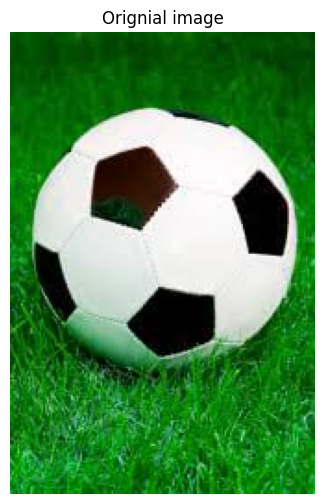

Selection complete!
pts_original = [[ 33.  59.]
 [ 92.  42.]
 [ 29. 143.]
 [124. 141.]]
pts_transformed = [[ 41.  67.]
 [101.  51.]
 [ 41. 156.]
 [136. 152.]]
projective transformation matrix =  [[1.11671280e+00 5.74259632e-02 1.87465445e+00]
 [6.86920911e-02 1.10775842e+00 1.19635744e+00]
 [5.88212488e-04 1.31648247e-04 1.00000000e+00]]


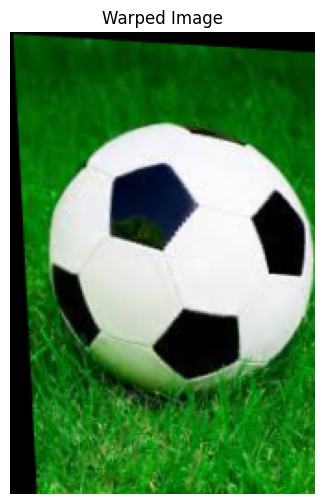

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load image
image = cv2.imread("images.jpeg")
height, width = image.shape[:2]

# === MAIN PROGRAM ===
if __name__ == "__main__":
    # Load image
    img = cv2.imread('images.jpeg', 1)

    # Display using Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.title("Orignial image")
    plt.show()

    
    # Call function and get selected points
    pts_original, pts_transformed = Capture_Points(img)

    # Print selected points
    print("pts_original =", pts_original)
    print("pts_transformed =", pts_transformed)


# Compute the projective transformation matrix
H = cv2.getPerspectiveTransform(pts_original, pts_transformed)
print("projective transformation matrix = ", H)

# Apply the transformation
warped_image = cv2.warpPerspective(image, H, (width, height))

# Convert BGR to RGB for correct display
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(warped_image_rgb)
plt.axis("off")  # Hide axes
plt.title("Warped Image")
plt.show()


## Applying Lucas-Kanade Optical Flow
We first convert both images to grayscale for efficient processing. Then, we detect strong feature points using cv2.goodFeaturesToTrack(), which finds high-contrast corners suitable for tracking.

Next, we apply Lucas-Kanade optical flow using cv2.calcOpticalFlowPyrLK(), which estimates how these feature points move between the original and warped images. The motion is computed by minimizing the brightness constancy error:

$$
I(x, y, t) = I(x + u, y + v, t + 1)
$$

(u,v) is the displacement vector. Finally, we filter out unreliable points to retain only successfully tracked features, which will be used for comparing estimated motion with ground truth.

In [3]:
# Convert images to grayscale
gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)


# Detect good features to track
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# Define parameters for Lucas-Kanade
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Compute the optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)

# Select good points
good_new = p1[st == 1]
good_old = p0[st == 1]


## Visualizing Optical Flow
We create a copy of the original image to draw motion tracks. Each tracked point is visualized by:

Green lines showing the displacement from the original to the new position.

Blue circles marking the new positions of the tracked points.

This visualization helps in analyzing how well Lucas-Kanade optical flow estimates small motion by comparing it with the ground truth transformation applied earlier.

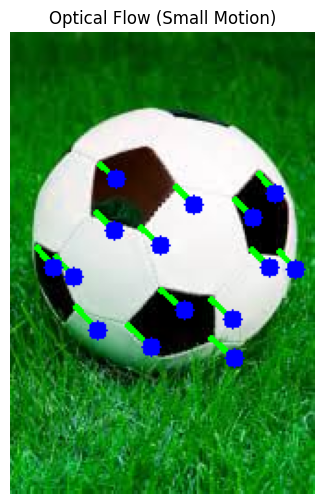

In [4]:
# Create a copy of the original image to draw optical flow
flow_img = image.copy()

# Draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(flow_img, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    cv2.circle(flow_img, (int(a), int(b)), 5, (0, 0, 255), -1)

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(flow_img)
plt.axis("off")  # Hide axes
plt.title("Optical Flow (Small Motion)")
plt.show()


## Evaluating Optical Flow Accuracy
To compare Lucas-Kanade optical flow with the ground truth transformation, we first convert the detected feature points (p0) into homogeneous coordinates by adding a third dimension (1) for matrix multiplication. We then apply the projective transformation matrix H to obtain the transformed points:

$$
p' = H \cdot p
$$

where p is the original point in homogeneous coordinates. After converting back to 2D, we compute the displacement error by measuring the Euclidean distance between the Lucas-Kanade estimated points (good_new) and the ground truth transformed points (p0_transformed). Finally, we calculate the mean error, which quantifies how accurately optical flow tracks motion.

In [5]:
# Convert p0 to homogeneous coordinates (add a 1 for matrix multiplication)
ones = np.ones((p0.shape[0], 1))
p0_homogeneous = np.hstack([p0.reshape(-1, 2), ones])

# Apply the projective transformation matrix H
p0_transformed = (H @ p0_homogeneous.T).T  # Matrix multiplication

# Convert back from homogeneous to 2D
p0_transformed = p0_transformed[:, :2] / p0_transformed[:, 2].reshape(-1, 1)

# Compute the displacement error
error = np.linalg.norm(good_new - p0_transformed, axis=1)

# Compute the mean error
mean_error_small = np.mean(error)

print(f"Mean Optical Flow Error (Small Motion): {mean_error_small:.4f} pixels")


Mean Optical Flow Error (Small Motion): 0.2278 pixels


## Comparing Optical Flow with Ground Truth
To visually compare the Lucas-Kanade optical flow results with the ground truth motion, we plot motion vectors for both:

Blue arrows represent the ground truth motion, i.e., the displacement calculated from the projective transformation.
Red arrows represent the Lucas-Kanade estimated motion, showing how well the optical flow method tracks the points.
This visualization helps us to assess the accuracy of Lucas-Kanade optical flow by directly comparing the estimated motion with the true transformation, offering a clear representation of the error or alignment between the two.

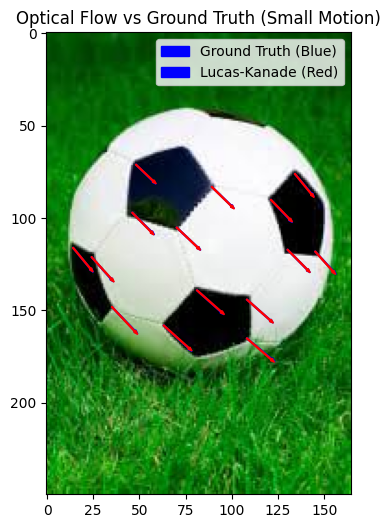

In [6]:
import matplotlib.pyplot as plt

# Plot the motion vectors
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot ground truth motion (blue)
for i in range(len(p0_transformed)):
    plt.arrow(p0[i, 0, 0], p0[i, 0, 1], 
              p0_transformed[i, 0] - p0[i, 0, 0], 
              p0_transformed[i, 1] - p0[i, 0, 1], 
              color='blue', width=0.5)

# Plot Lucas-Kanade estimated motion (red)
for i in range(len(good_new)):
    plt.arrow(p0[i, 0, 0], p0[i, 0, 1], 
              good_new[i, 0] - p0[i, 0, 0], 
              good_new[i, 1] - p0[i, 0, 1], 
              color='red', width=0.5)

plt.legend(["Ground Truth (Blue)", "Lucas-Kanade (Red)"])
plt.title("Optical Flow vs Ground Truth (Small Motion)")
plt.show()


## Applying Affine Transformation
To perform affine transformation, we start by selecting the first three points from both the original and transformed point sets. These points define a linear transformation that preserves parallelism and relative distances, but not angles or sizes.

Using cv2.getAffineTransform(), we compute the affine transformation matrix A that maps the selected points in the original image to their corresponding locations in the transformed image. This matrix is then used to apply the affine transformation to the original image using cv2.warpAffine().

Finally, we display the affine-transformed image with Matplotlib, allowing us to visualize the effect of the affine transformation. This step simulates a rigid motion (rotation, translation, scaling) on the image. The result is useful for comparing with optical flow results, especially when handling larger motions.

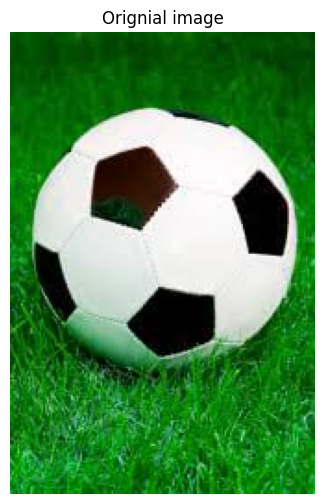

pts_original = [[ 39.  50.]
 [ 72. 131.]
 [128.  56.]]
pts_transformed = [[ 65.  67.]
 [ 96. 147.]
 [154.  79.]]
affine transformation matrix =  [[ 1.00171160e+00 -2.53886749e-02  2.72026815e+01]
 [ 7.01754386e-02  9.59064327e-01  1.63099415e+01]]


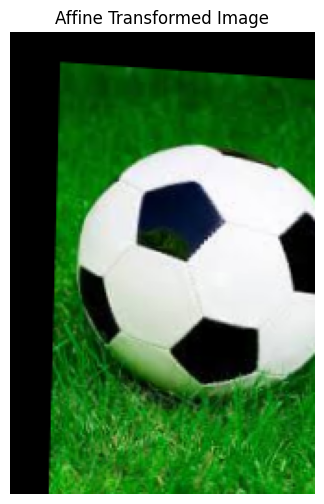

True

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Load image
    img = cv2.imread('images.jpeg', 1)

    # Display using Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.title("Orignial image")
    plt.show()

    
    # Call function and get selected points
    pts_original, pts_transformed = Capture_Points(img)

    # Print selected points
    print("pts_original =", pts_original)
    print("pts_transformed =", pts_transformed)

# Select the first 3 points for affine transformation
pts_original_affine = pts_original[:3]  # Take first 3 points
pts_transformed_affine = pts_transformed[:3]  # Take first 3 transformed points

# Compute the affine transformation matrix
A = cv2.getAffineTransform(pts_original_affine, pts_transformed_affine)

print("affine transformation matrix = ", A)
# Apply the affine transformation
affine_img = cv2.warpAffine(image, A, (width, height))

# Convert BGR to RGB for Matplotlib
affine_img_rgb = cv2.cvtColor(affine_img, cv2.COLOR_BGR2RGB)

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(affine_img_rgb)
plt.axis("off")  # Hide axes
plt.title("Affine Transformed Image")
plt.show()

# Optional: Save the transformed image
cv2.imwrite("affine_transformed.jpg", affine_img)


## Visualizing Optical Flow with Affine Transformation
We apply Lucas-Kanade optical flow to track the movement of feature points between the original image and the affine-transformed image. After converting both images to grayscale, we detect good feature points using cv2.goodFeaturesToTrack(). The optical flow is then computed using cv2.calcOpticalFlowPyrLK(), which estimates the motion of these points between the two images.

We visualize the optical flow tracks on the original image by drawing:

Green lines indicating the displacement between the original and estimated new points.
Blue circles representing the new locations of the tracked points.
This allows us to assess how well optical flow tracks features even after applying an affine transformation, which involves translation, rotation, scaling, or shear, showing the performance of optical flow for larger motions compared to small motion.

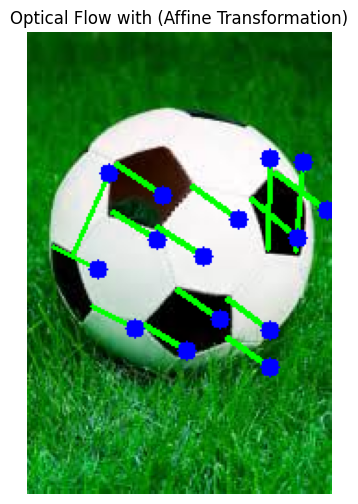

In [13]:
# Convert images to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(affine_img_rgb, cv2.COLOR_BGR2GRAY)

# Detect good features to track
p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# Compute optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)

# Select good points
good_new = p1[st == 1]
good_old = p0[st == 1]


# Create a copy of the original image to draw optical flow
flow_img = image.copy()

# Draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(flow_img, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    cv2.circle(flow_img, (int(a), int(b)), 5, (0, 0, 255), -1)

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(flow_img)
plt.axis("off")  # Hide axes
plt.title("Optical Flow with (Affine Transformation)")
plt.show()



## Evaluating Optical Flow with Affine Transformation
To evaluate the optical flow accuracy, we first convert the original points (p0) to homogeneous coordinates by appending a 1 for matrix multiplication. We then apply the affine transformation matrix (A) to the points, resulting in transformed points.

Next, we filter the transformed points to match only those that were successfully tracked by optical flow (i.e., the points with status st == 1). The displacement error is computed by measuring the Euclidean distance between the transformed points and the estimated flow points (good_new), which represent the movement tracked by optical flow.

Finally, we calculate the mean error to quantify the average accuracy of the optical flow estimation:

$$
\text{Error} = \| p_{\text{new}} - p_{\text{transformed}} \|
$$

The mean error gives an overall measure of how well the optical flow tracks points after an affine transformation, with the lower the error indicating better performance.

In [14]:
# Convert p0 to homogeneous coordinates (append a 1 for matrix multiplication)
ones = np.ones((p0.shape[0], 1))
p0_homogeneous = np.hstack([p0.reshape(-1, 2), ones])

# Apply the affine transformation
p0_transformed = (A @ p0_homogeneous.T).T  # Matrix multiplication

# Filter p0_transformed to match the indices of successfully tracked points
p0_transformed_filtered = p0_transformed[st.flatten() == 1]

# Now compute the displacement error
error = np.linalg.norm(good_new - p0_transformed_filtered, axis=1)

# Compute the mean error
mean_error_affine = np.mean(error)

print(f"Mean Optical Flow Error: {mean_error_affine:.4f} pixels")


Mean Optical Flow Error: 14.0176 pixels


## Comparing Optical Flow with Ground Truth (Affine Motion)
In this visualization, we compare the ground truth motion (blue arrows) and the Lucas-Kanade estimated motion (red arrows) on the original image.

Ground truth (blue arrows) represents the actual displacement of the feature points after the affine transformation.
Lucas-Kanade estimated motion (red arrows) represents the motion that was tracked using the optical flow algorithm.
The arrows start at the original positions of the points and point toward their respective transformed positions, with the blue arrows indicating the expected motion due to the affine transformation and the red arrows showing the motion predicted by Lucas-Kanade optical flow.

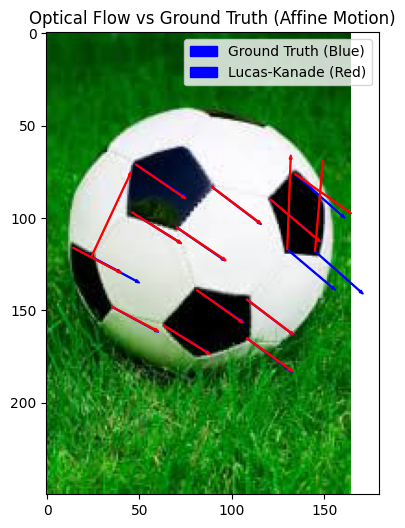

In [15]:
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Ground truth motion (Blue)
for i in range(len(p0_transformed)):
    plt.arrow(p0[i, 0, 0], p0[i, 0, 1], 
              p0_transformed[i, 0] - p0[i, 0, 0], 
              p0_transformed[i, 1] - p0[i, 0, 1], 
              color='blue', width=0.5)

# Lucas-Kanade estimated motion (Red)
for i in range(len(good_new)):
    plt.arrow(p0[i, 0, 0], p0[i, 0, 1], 
              good_new[i, 0] - p0[i, 0, 0], 
              good_new[i, 1] - p0[i, 0, 1], 
              color='red', width=0.5)

plt.legend(["Ground Truth (Blue)", "Lucas-Kanade (Red)"])
plt.title("Optical Flow vs Ground Truth (Affine Motion)")
plt.show()


In [16]:

# Output the result in a conclusion
if mean_error_affine > mean_error_small:
    print("Lucas-Kanade performs better for small motion and struggles with larger affine transformations.")
else:
    print("Lucas-Kanade performs well under both conditions.")


Lucas-Kanade performs better for small motion and struggles with larger affine transformations.


# Conclusion:

The results show that the Lucas-Kanade optical flow method works well for small motions and struggles with large affine transformations. This is a limitation of the algorithm, as it assumes that the motion is small and local, making it less suitable for handling more complex and larger deformations in the image. For larger motions, alternative methods or enhancements to the basic Lucas-Kanade algorithm, such as pyramid-based approaches or global motion models, may be more effective.

Overall, this project helped to highlight the limitations of the Lucas-Kanade method in the context of large affine transformations and provided insights into the challenges of optical flow estimation in real-world applications where complex motion often occurs.

# References

For optical Flow:
Opencv
https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html

For Perspective Transformation:
Geeksforgeeks
https://www.geeksforgeeks.org/perspective-transformation-python-opencv/

For Affine Transformation:
Geeksforgeeks
https://www.geeksforgeeks.org/python-opencv-affine-transformation/
